In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1
import ipdb

In [2]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets['tone'] = 0

In [3]:
neg_tweets

,0,1,2,text,tone,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,0,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,0,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",0,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",0,0,0,0,35,17,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...
111918,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,0,0,0,0,1138,32,46,0
111919,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,0,0,0,0,4822,38,32,0
111920,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",0,0,0,1,165,13,16,0
111921,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0,0,1,0,2516,187,265,0


In [4]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
pos_tweets

,0,1,2,text,tone,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
114906,411368729235054592,1386912922,diminlisenok,"Спала в родительском доме, на своей кровати......",1,0,0,0,1497,56,34,2
114907,411368729424187392,1386912922,qilepocagotu,RT @jebesilofyt: Эх... Мы немного решили сокра...,1,0,1,0,692,225,210,0
114908,411368796537257984,1386912938,DennyChooo,"Что происходит со мной, когда в эфире #proacti...",1,0,0,0,4905,448,193,13
114909,411368797447417856,1386912938,bedowabymir,"""Любимая,я подарю тебе эту звезду..."" Имя како...",1,0,0,0,989,254,251,0


In [5]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [6]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]
tweets_data

,text,tone
75460,RT @yuliaamay: Аюю который день подрят фастфуд...,0
3532,"RT @dejemutofuc: Написать можно все,а жизнь за...",0
102209,@bes_ala @_JulS_Mp спасибо за пинки... Расклеи...,0
59755,@garibio сейчас ветрянка мутировала и все по в...,0
22763,надо ей каждый вечер звонить :)\nнастроение по...,1
...,...,...
84334,"@AngelinaMukhina почему?кстати,в фильме,судя п...",1
93143,"Ну пока, до февраля!!((@GalimovaKamila http://...",0
29135,"""Женщины умирают позже мужчин, потому что вечн...",1
74568,"От такой красоты, глазам больно:). Есть у нас ...",1


In [7]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [8]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [9]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 203018


In [10]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 2 раз: 32273


In [11]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [13]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [14]:
MAX_LEN = 0

for text in tweets_data.text:
    tokens = preprocess(text)
    MAX_LEN = max(len(tokens), MAX_LEN)
MAX_LEN

37

In [15]:
X = torch.LongTensor(size=(train_sentences.shape[0], MAX_LEN))

for i, text in enumerate(train_sentences.text):
    tokens = preprocess(text) # токенизируем
    ids = [word2id[token] for token in tokens if token in word2id][:MAX_LEN]    
    ids = F.pad(torch.LongTensor(ids), (0,MAX_LEN-len(ids)))

    X[i] = ids

In [16]:
print(X[4].shape)
print(X[4])
print([id2word[int(id_)] for id_ in  X[4]])

torch.Size([37])
tensor([29489, 27233,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])
['rt', 'смотрю', '', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


In [17]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids, y

In [18]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [19]:
batch = next(iter(train_iterator))

In [20]:
batch

(tensor([[ 1679, 20171,   309,  ...,     0,     0,     0],
         [27393, 19822, 26528,  ...,     0,     0,     0],
         [ 3981, 30174,  5412,  ...,     0,     0,     0],
         ...,
         [20051, 14026,  1679,  ...,     0,     0,     0],
         [18780, 13435, 20151,  ...,     0,     0,     0],
         [ 8207, 28272, 31317,  ...,     0,     0,     0]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [0.]], device='cuda:0'))

In [21]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [22]:
test_batch = next(iter(val_iterator))

In [23]:
fm = torch.randn(3, 8, 4) #batch_size, num_filters, seq_len
fm

tensor([[[-0.1093, -0.2447, -1.5321, -0.3812],
         [ 0.7615,  0.2462, -0.6485,  0.0278],
         [-2.1325,  0.7401, -1.4244, -0.7704],
         [-0.7850, -0.2592,  0.9014, -2.3861],
         [ 0.8192, -0.3471, -2.1244, -0.1641],
         [ 0.0262, -0.0514, -0.6023, -0.8927],
         [-1.5651,  0.0790,  1.2194, -1.5271],
         [-2.0382, -0.6440, -1.2946, -1.4640]],

        [[-1.1925, -0.2027,  0.8993,  0.4009],
         [-0.8971,  1.3917,  0.3494, -0.6296],
         [-1.1048,  0.1708, -0.4701, -1.7269],
         [ 0.2814, -1.3923,  0.1301,  1.3742],
         [ 1.5471,  0.0479,  2.2346,  1.1110],
         [ 1.4908, -0.2033,  1.7546, -0.8361],
         [ 0.4010, -1.2563, -1.1384, -1.4751],
         [ 2.0340, -0.0769, -0.6452, -0.1621]],

        [[-1.9261,  0.1020,  0.1430, -0.3895],
         [-0.6592, -0.2963, -1.1790, -1.3884],
         [-0.3490, -0.7300,  0.4479, -1.6052],
         [-0.9273, -2.7126,  0.5865, -0.1593],
         [ 0.0747, -0.9695,  1.2503,  0.4262],
         

In [24]:
mp = torch.nn.MaxPool1d(kernel_size=2, stride=2)
print(mp(fm).shape)
mp(fm)

torch.Size([3, 8, 2])


tensor([[[-0.1093, -0.3812],
         [ 0.7615,  0.0278],
         [ 0.7401, -0.7704],
         [-0.2592,  0.9014],
         [ 0.8192, -0.1641],
         [ 0.0262, -0.6023],
         [ 0.0790,  1.2194],
         [-0.6440, -1.2946]],

        [[-0.2027,  0.8993],
         [ 1.3917,  0.3494],
         [ 0.1708, -0.4701],
         [ 0.2814,  1.3742],
         [ 1.5471,  2.2346],
         [ 1.4908,  1.7546],
         [ 0.4010, -1.1384],
         [ 2.0340, -0.1621]],

        [[ 0.1020,  0.1430],
         [-0.2963, -1.1790],
         [-0.3490,  0.4479],
         [-0.9273,  0.5865],
         [ 0.0747,  1.2503],
         [ 0.6379, -0.5543],
         [-1.3106,  0.1294],
         [-0.3018,  0.7460]]])

In [25]:
fm.max(2)[0]

tensor([[-0.1093,  0.7615,  0.7401,  0.9014,  0.8192,  0.0262,  1.2194, -0.6440],
        [ 0.8993,  1.3917,  0.1708,  1.3742,  2.2346,  1.7546,  0.4010,  2.0340],
        [ 0.1430, -0.2963,  0.4479,  0.5865,  1.2503,  0.6379,  0.1294,  0.7460]])

In [26]:
batch, y = next(iter(train_iterator))
batch, y = batch, y

In [27]:
# tryhard
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.sec_conv = nn.Conv1d(in_channels=200, out_channels=100, kernel_size=3, padding='same')

        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        #print(feature_map_bigrams.shape)
        #print(feature_map_trigrams.shape)
        
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        third_conv = self.dropout(self.pooling(self.sec_conv(concat)))
        pooling1 = third_conv.max(2)[0]

        logits = self.hidden(pooling1) 
        logits = self.out(logits)      
        return logits

model = CNN(len(id2word), 8)
model.cuda()
output = model(batch)
print(output)

C:\Users\trekc\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\conv.py:297: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:647.)
  return F.conv1d(input, weight, bias, self.stride,


tensor([[0.4144],
        [0.4028],
        [0.4201],
        ...,
        [0.3885],
        [0.4419],
        [0.4758]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [28]:
batch, y

(tensor([[12472,  5412, 14750,  ...,     0,     0,     0],
         [ 7081, 20051,  3820,  ...,     0,     0,     0],
         [14982,  3568,  5551,  ...,     0,     0,     0],
         ...,
         [ 7569,  5412, 14404,  ...,     0,     0,     0],
         [29489,  5412, 14484,  ...,     0,     0,     0],
         [20051, 31786, 21181,  ...,     0,     0,     0]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [0.],
         ...,
         [1.],
         [1.],
         [0.]], device='cuda:0'))

In [29]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.7040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [30]:
f1(output, y.long())

tensor(0.0117, device='cuda:0')

# TRAIN

In [31]:
def train(model, iterator, optimizer, criterion, metric):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    epoch_metric = 0
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
        epoch_metric += batch_metric
        if not (i + 1) % 20:
            print(f'Train loss: {loss.item()}, Train f1: {batch_metric}')
            #print(f'Train loss: {epoch_loss/i}, Train f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [32]:
def evaluate(model, iterator, criterion, metric):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = metric(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % 20:
              print(f'Val loss: {loss.item()}, Val f1: {batch_metric}')
              #print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [33]:
def learning(n_epochs, model, optimizer, criterion):
    for i in range(n_epochs):
        print(f'\nstarting Epoch {i}')
        f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, metric=f1)
        losses.append(epoch_loss)
        f1s.append(f1_value.cpu())

        f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, metric=f1)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_value_on_test.cpu())

In [80]:
model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

learning(20, model, optimizer, criterion)


starting Epoch 0
Training...
Train loss: 0.691584050655365, Train f1: 0.6551475524902344
Train loss: 0.6892647743225098, Train f1: 0.4542447626590729
Train loss: 0.6812264323234558, Train f1: 0.5447070598602295
Train loss: 0.6698874235153198, Train f1: 0.5650793313980103

Validating...

starting Epoch 1
Training...
Train loss: 0.677777111530304, Train f1: 0.6499214768409729
Train loss: 0.6617717146873474, Train f1: 0.6628664135932922
Train loss: 0.6401649713516235, Train f1: 0.6605672836303711
Train loss: 0.6464149355888367, Train f1: 0.6672185659408569

Validating...

starting Epoch 2
Training...
Train loss: 0.6413226127624512, Train f1: 0.6553570628166199
Train loss: 0.6382930874824524, Train f1: 0.6254902482032776
Train loss: 0.6295737028121948, Train f1: 0.6537396311759949
Train loss: 0.6326467990875244, Train f1: 0.6755319237709045

Validating...

starting Epoch 3
Training...
Train loss: 0.5958954691886902, Train f1: 0.6141906976699829
Train loss: 0.6126894950866699, Train f1: 0.

In [35]:
100, 100, 80 - 0,46
50, 50, 50 - 0,47
150, 150, 150 - 0,46


(150, 150, 150, 46)

In [36]:
import matplotlib.pyplot as plt
def printer_bce():
    plt.plot(losses)
    plt.plot(losses_eval)
    plt.title('BCE loss value')
    plt.ylabel('BCE loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [37]:
def printer_f1():
    plt.plot(f1s)
    plt.plot(f1s_eval)
    plt.title('f1 value')
    plt.ylabel('f1 value')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

# Оценка

In [38]:
for x, y in val_iterator:
    print(x, y)
    break

tensor([[14982,  7460, 25748,  ...,     0,     0,     0],
        [27945, 13973, 24408,  ...,     0,     0,     0],
        [19040,  7988, 27399,  ...,     0,     0,     0],
        ...,
        [ 3079, 30899, 31411,  ...,     0,     0,     0],
        [ 5988, 22960, 11523,  ...,     0,     0,     0],
        [13435,  8442, 11523,  ...,     0,     0,     0]], device='cuda:0') tensor([[0.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], device='cuda:0')


In [39]:
from tqdm import tqdm


def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in tqdm(enumerate(iterator)):
            preds = model(texts)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

fp, fn, tp, tn = predict(model, val_iterator)

10it [00:35,  3.52s/it]


In [40]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7004549783091737

Хз что ему не нравится, я обучал на большем количестве эпох, все ок тогда

In [41]:
fn[:10]

['photo два допуска журнал препода по лабы студенты физика',
 'оп вышел',
 'все планы накрылись настроение',
 'ахаха как же по пофоткаться на катке пока ждешь',
 'как ни крути но я все равно буду помнить все те моменты с тобой те 5 лет',
 'мои планы на нг 1 посмотреть путина 2 выпить с родными шампанское 3 пожрать 4 идти на улицу гулять',
 'мы она такая большая скоро она станет скороновыйгод',
 '2 месяца так быстро они не заметили',
 'листок с обо мне попал случайно к вове вопрос про заставил',
 'быть рыбой не круто ты чо забыл видос с рыбой']

In [42]:
fp[:10]

['если бы ты он мне бы ни чего не сказала',
 '31 декабря у меня в доме и много ещё где нет света я давно такого не наблюдал',
 'фак мой моск у моего бедного уже за пора думать о',
 'кто не пойдет на мк правильно я',
 'упустил концовку надо пересматривать',
 'simbiblis oleg_ilchenko теперь я понял что паспорта святой дух и смех и грех к чему идем',
 'доктор педики и тупо послали хотя ранее по этому уже и послали',
 'как дела во мы в нг туда нас пугают и отношением в',
 'она еби он это намёк что секса не будет она надела a4f',
 'да']

Embeddings<br>
Подумал, что сохраню в дф препроцесенные значения, чтобы не делать много раз

In [43]:
tweets_data['preproc1_text'] = tweets_data.text.apply(lambda text: ' '.join(preprocess(text)))

In [44]:
texts = tweets_data.preproc1_text.tolist()

In [45]:
texts

['rt yuliaamay аюю который день подрят фастфудом питаюсь  дьаабы',
 'rt dejemutofuc написать можно все,а жизнь занова переписать нет',
 'bes_ala juls_mp спасибо за пинки расклеилась я',
 'garibio сейчас ветрянка мутировала и все по второму разу пошли ',
 'надо ей каждый вечер звонить  настроение поднимать',
 'на вокзале покупаю билеты маме в харьков очередь',
 'soofckngwhat вот я так и знала',
 'я не особо в восторге от спектакля"вий но гомосексуальная тема была внезапной ',
 'partyzanekat я понял спасибо непривычно я перекресток крауля-токарей вспомнил был слегка в шоке',
 'жуйкую команду ы функция рекомендация+подписка на комментарии ',
 'volonskaya_j у всех не работает 37 exabeliebers',
 'ава у тебя супер это те фотки когда ты для меня фоткалась да',
 'порой листаю фотки в инстаграмме и не понимаю кто или что на фото все однообразно как-то аж плакать хочется',
 'сколько рук коды это вообще о чем почему мне задают такие вопросы о_о',
 'сестра нацепила на руку мою фенечку с найтами и 

In [46]:
from gensim.models import FastText

In [47]:
fasttext = FastText(texts, vector_size=100, window=5, min_count=1)

In [48]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = fasttext.wv[word]    
    except KeyError:
        count += 1
      # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,100)

In [49]:
class CNN_fasttext(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.sec_conv = nn.Conv1d(in_channels=200, out_channels=100, kernel_size=3, padding='same')

        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        #print(feature_map_bigrams.shape)
        #print(feature_map_trigrams.shape)
        
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        third_conv = self.dropout(self.pooling(self.sec_conv(concat)))
        pooling1 = third_conv.max(2)[0]

        logits = self.hidden(pooling1) 
        logits = self.out(logits)      
        return logits

In [50]:
fast_model = CNN(len(word2id), 5)
fast_optimizer = optim.Adam(fast_model.parameters(), lr=0.001)
fast_criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
fast_model = fast_model.to(DEVICE)
fast_criterion = fast_criterion.to(DEVICE)

In [51]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

learning(20, fast_model, fast_optimizer, fast_criterion)


starting Epoch 0
Training...
Train loss: 0.6880130767822266, Train f1: 0.6685314774513245
Train loss: 0.6874606013298035, Train f1: 0.4780157804489136
Train loss: 0.6831316947937012, Train f1: 0.5381526350975037
Train loss: 0.6848927140235901, Train f1: 0.592391312122345

Validating...

starting Epoch 1
Training...
Train loss: 0.6636877655982971, Train f1: 0.5733461380004883
Train loss: 0.6662214994430542, Train f1: 0.5912547707557678
Train loss: 0.6726099252700806, Train f1: 0.4784688651561737
Train loss: 0.6721168160438538, Train f1: 0.5559105277061462

Validating...

starting Epoch 2
Training...
Train loss: 0.6507867574691772, Train f1: 0.6180344223976135
Train loss: 0.6613276600837708, Train f1: 0.6000000238418579
Train loss: 0.6511105298995972, Train f1: 0.5829875469207764
Train loss: 0.6385085582733154, Train f1: 0.622885525226593

Validating...

starting Epoch 3
Training...
Train loss: 0.6399675011634827, Train f1: 0.6371347308158875
Train loss: 0.6374061703681946, Train f1: 0.

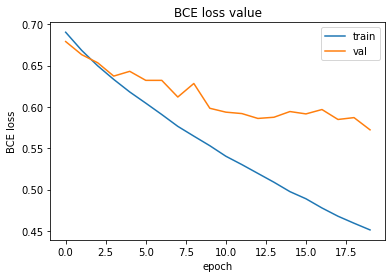

In [52]:
printer_bce()

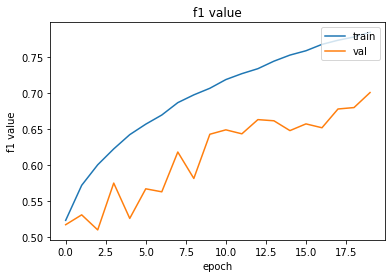

In [53]:
printer_f1()

In [54]:
fp, fn, tp, tn = predict(fast_model, val_iterator)

10it [00:38,  3.83s/it]


In [55]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7011696511748267

In [56]:
fn[:10]

['все планы накрылись настроение',
 'хах я случайно сидел твитты читал и нажал случайно',
 'как ни крути но я все равно буду помнить все те моменты с тобой те 5 лет',
 'мои планы на нг 1 посмотреть путина 2 выпить с родными шампанское 3 пожрать 4 идти на улицу гулять',
 'rt именно так сейчас я представляю мать родину',
 'быть рыбой не круто ты чо забыл видос с рыбой',
 'если я всегда буду делать уроки заранее и не оставлять все на последний день то у меня будет больше свободного времени',
 'не спорю но я за твои нервные клетки беспокоюсь у самой такая же ситуация только ещё хуже с паспортом',
 'из видел не раз только людей у которых глаза разного цвета',
 'rt пиши больше я скучаю']

### Пользы особо не принесло.
##### Попробую предобработать корпус, оставив фасттекст

In [57]:
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [58]:
import re
tweets_data['preproc2_text'] = tweets_data.text.apply(lambda text: preprocess_text(text))

In [59]:
texts = tweets_data.preproc2_text.tolist()
texts

['rt USER аюю который день подрят фастфудом питаюсь дьаабы',
 'rt USER написать можно все а жизнь занова переписать нет',
 'USER USER спасибо за пинки расклеилась я',
 'USER сейчас ветрянка мутировала и все по второму разу пошли',
 'надо ей каждый вечер звонить настроение поднимать',
 'на вокзале покупаю билеты маме в харьков очередь',
 'USER вот я так и знала',
 'я не особо в восторге от спектакля вий но гомосексуальная тема была внезапной',
 'USER я понял спасибо непривычно я перекресток крауля токарей вспомнил был слегка в шоке',
 'жуйкую команду ы функция рекомендация подписка на комментарии',
 'USER у всех не работает 37 exabeliebers',
 'ава у тебя супер это те фотки когда ты для меня фоткалась да',
 'порой листаю фотки в инстаграмме и не понимаю кто или что на фото все однообразно как то аж плакать хочется',
 'сколько рук коды это вообще о чем почему мне задают такие вопросы о о',
 'сестра нацепила на руку мою фенечку с найтами и попыталась прочитать название группы я давно так н

In [60]:
fasttext_preproc2 = FastText(texts, vector_size=100, window=5, min_count=1)

In [61]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = fasttext_preproc2.wv[word]    
    except KeyError:
        count += 1
      # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,100)

In [62]:
fast_model2 = CNN_fasttext(len(word2id), 5)
fast_optimizer2 = optim.Adam(fast_model2.parameters(), lr=0.001)
fast_criterion2 = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
fast_model2 = fast_model2.to(DEVICE)
fast_criterion2 = fast_criterion2.to(DEVICE)

In [63]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

learning(20, fast_model2, fast_optimizer2, fast_criterion2)


starting Epoch 0
Training...
Train loss: 0.688811182975769, Train f1: 0.6351457834243774
Train loss: 0.6855489015579224, Train f1: 0.4728950560092926
Train loss: 0.677021861076355, Train f1: 0.6661631464958191
Train loss: 0.6751757264137268, Train f1: 0.607929527759552

Validating...

starting Epoch 1
Training...
Train loss: 0.6636175513267517, Train f1: 0.5647298693656921
Train loss: 0.6606447696685791, Train f1: 0.5911824107170105
Train loss: 0.6621430516242981, Train f1: 0.5468577742576599
Train loss: 0.6737513542175293, Train f1: 0.6039426922798157

Validating...

starting Epoch 2
Training...
Train loss: 0.652637243270874, Train f1: 0.6534823775291443
Train loss: 0.658301055431366, Train f1: 0.5944882035255432
Train loss: 0.6487930417060852, Train f1: 0.6022610068321228
Train loss: 0.6370443105697632, Train f1: 0.5895439386367798

Validating...

starting Epoch 3
Training...
Train loss: 0.6412058472633362, Train f1: 0.6475485563278198
Train loss: 0.6546307802200317, Train f1: 0.537

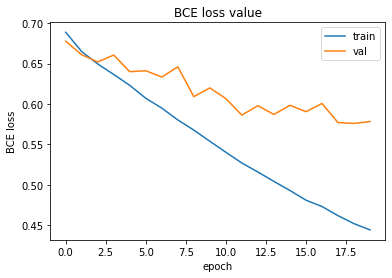

In [64]:
printer_bce()

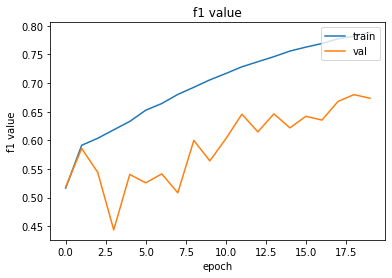

In [65]:
printer_f1()

In [66]:
fp, fn, tp, tn = predict(fast_model, val_iterator)

10it [00:36,  3.68s/it]


In [67]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7011696511748267

Ну хрень а не улучшения. Добавлю лемматизацию

In [68]:
words = ['пама', 'вама']
' '.join([word for word in words])

'пама вама'

In [69]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def preprocess_lemm_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    text = [morph.parse(word)[0].normal_form for word in text.split()]

    return ' '.join(text)

In [70]:
tweets_data['preproc2_lemm_text'] = tweets_data.text.apply(lambda text: preprocess_lemm_text(text))

In [71]:
texts = tweets_data.preproc2_lemm_text.tolist()
texts

['rt user аюю который день подрить фастфуд питаться дьааба',
 'rt user написать можно всё а жизнь зановый переписать нет',
 'user user спасибо за пинок расклеиться я',
 'user сейчас ветрянка мутировать и всё по второй раз послать',
 'надо она каждый вечер звонить настроение поднимать',
 'на вокзал покупать билет мама в харьков очередь',
 'user вот я так и знать',
 'я не особо в восторг от спектакль вий но гомосексуальный тема быть внезапный',
 'user я понять спасибо непривычно я перекрёсток крауль токарь вспомнить быть слегка в шок',
 'жуйковать команда ы функция рекомендация подписка на комментарий',
 'user у весь не работать 37 exabeliebers',
 'ава у ты супер это тот фотка когда ты для я фоткаться да',
 'порой листать фотка в инстаграмм и не понимать кто или что на фото всё однообразно как то аж плакать хотеться',
 'сколько рука код это вообще о чем почему я задавать такой вопрос о о',
 'сестра нацепить на рука мой фенёчек с найта и попытаться прочитать название группа я давно так не

In [72]:
fasttext_preproc2_lemm = FastText(texts, vector_size=100, window=5, min_count=1)

In [73]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = fasttext_preproc2_lemm.wv[word]    
    except KeyError:
        count += 1
      # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,100)

In [74]:
fast_model2_lemm = CNN_fasttext(len(word2id), 5)
fast_optimizer2_lemm = optim.Adam(fast_model2_lemm.parameters(), lr=0.001)
fast_criterion2_lemm = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
fast_model2_lemm = fast_model2_lemm.to(DEVICE)
fast_criterion2_lemm = fast_criterion2_lemm.to(DEVICE)

In [75]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

learning(20, fast_model2_lemm, fast_optimizer2_lemm, fast_criterion2_lemm)


starting Epoch 0
Training...
Train loss: 0.6925129890441895, Train f1: 0.48445871472358704
Train loss: 0.6872743964195251, Train f1: 0.4264705777168274
Train loss: 0.6851778030395508, Train f1: 0.6350710988044739
Train loss: 0.6830954551696777, Train f1: 0.5708848237991333

Validating...

starting Epoch 1
Training...
Train loss: 0.6818368434906006, Train f1: 0.5906643271446228
Train loss: 0.6809147000312805, Train f1: 0.5845004320144653
Train loss: 0.6872945427894592, Train f1: 0.5603038668632507
Train loss: 0.6750056147575378, Train f1: 0.6267123818397522

Validating...

starting Epoch 2
Training...
Train loss: 0.6658186316490173, Train f1: 0.6370623111724854
Train loss: 0.6623848676681519, Train f1: 0.5462458729743958
Train loss: 0.6522040367126465, Train f1: 0.6242660880088806
Train loss: 0.6539496779441833, Train f1: 0.5881187915802002

Validating...

starting Epoch 3
Training...
Train loss: 0.6595580577850342, Train f1: 0.573822021484375
Train loss: 0.6430557370185852, Train f1: 

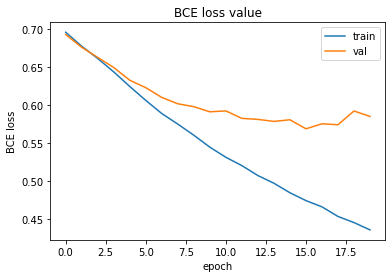

In [76]:
printer_bce()

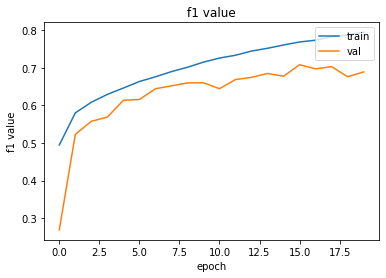

In [77]:
printer_f1()

In [78]:
fp, fn, tp, tn = predict(fast_model, val_iterator)

10it [00:35,  3.53s/it]


In [79]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7011696511748267

Разницы особо нет, попро